In [2]:
import pandas as pd
import numpy as np
import matplotlib
import torch
from glob import glob
import os
import json
from ecog_speech import datasets, feature_processing, experiments, utils
from ecog_speech.models import base
from tqdm.auto import tqdm

%matplotlib inline

### Load result JSON files into a list of objects

In [1]:
from ecog_speech import result_parsing

/home/morgan/.conda/envs/venv/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [3]:
# Link a results dir in the project root
base_path = "../ecog_speech/results_per_patient_sn_2105/"
result_files = glob(os.path.join(base_path, '*.json'))

json_result_data = [json.load(open(f)) for f in tqdm(result_files)]

Parse into dataframe

In [4]:
results_df = pd.DataFrame(json_result_data).sort_values('f1', ascending=False)

results_df.columns

Index(['name', 'datetime', 'uid', 'batch_losses', 'best_model_epoch',
       'num_trainable_params', 'num_params', 'model_kws', 'clf_reports', 'f1',
       'accuracy', 'precision', 'recall', 'model_name', 'dataset',
       'train_sets', 'cv_sets', 'test_sets', 'random_labels', 'learning_rate',
       'dense_width', 'sn_n_bands', 'sn_kernel_size', 'sn_padding',
       'n_cnn_filters', 'dropout', 'dropout_2d', 'in_channel_dropout_rate',
       'batchnorm', 'roll_channels', 'shuffle_channels', 'cog_attn',
       'bw_reg_weight', 'track_sinc_params', 'power_q', 'n_epochs',
       'batch_size', 'device', 'save_model_path', 'tag', 'result_dir',
       'low_hz_frame', 'high_hz_frame', 'path'],
      dtype='object')

Config params are those parameters we want to split by if experiments were run with different values
- Use pandas to detect which config parameters were actually changed from the provided superset

In [5]:
import seaborn as sns

# Choose a metric
perf_col = 'f1'

performance_cols = ['accuracy', 'f1', 'precision']
config_params = ['model_name', 'dataset', 'dense_width',
                 'sn_n_bands', 'sn_kernel_size', 'sn_padding',
                 'bw_reg_weight', 'cog_attn', 'shuffle_channels',
                 'n_cnn_filters', 'dropout', 'dropout_2d', 'in_channel_dropout_rate',
                 'batchnorm', 'roll_channels', 'power_q', 'n_epochs']

results_df['bw_reg_weight'] = results_df['bw_reg_weight'].fillna(-1)
results_df['test_patient'] = results_df['test_sets'].str.split('-').apply(lambda l: '-'.join(l[:-1]))
results_df['test_fold'] = results_df['test_sets'].str.split('-').apply(lambda l: l[-1])

In [6]:
nun_config_params = results_df[config_params].nunique()

config_cols = nun_config_params[nun_config_params > 1].index.tolist()
fixed_config_cols = nun_config_params[nun_config_params == 1].index.tolist()
print(f"Fixed Params: {', '.join(fixed_config_cols)}")
print(f"Changing Params: {', '.join(config_cols)}")

Fixed Params: model_name, dataset, sn_kernel_size, sn_padding, bw_reg_weight, cog_attn, shuffle_channels, dropout, dropout_2d, batchnorm, roll_channels, power_q, n_epochs
Changing Params: sn_n_bands, n_cnn_filters, in_channel_dropout_rate


### What did we load? Patient and model type counts 
- Which patients are there results on, for which datasets

In [7]:
pd.crosstab(results_df.test_patient, results_df.model_name)

model_name,base-sn
test_patient,
MC-19,32
MC-24,72
MC-25,48


### A unique experiment is a combination of the **_configuration parameters_**, a **_test_patient_**, and the **_test_fold_**
    - **configuraiton parameters**: All configuration parameters to consider in variable `config_params`, but the ones that vary in the experiments loaded are stored in `config_cols` and the remaining are in `fixed_config_cols`. We are generally interested in how performance and output changes between these various combinations of configurations.
    - **test_patient** and **test_fold**: Each patient has at least 2 trials available, so k-fold at the trial level will result in multiple fits per model config, but with varying train/test sets. We want to aggregate these folds (mean/std) to understand a model configurations performance on a patient.

In [8]:
results_df[performance_cols + config_params].describe(include='all')

,accuracy,f1,precision,model_name,dataset,dense_width,sn_n_bands,sn_kernel_size,sn_padding,bw_reg_weight,cog_attn,shuffle_channels,n_cnn_filters,dropout,dropout_2d,in_channel_dropout_rate,batchnorm,roll_channels,power_q,n_epochs
count,152.000000,152.000000,152.000000,152,152,0,152.000000,152.0,152.0,152.0,152,152,152.000000,152.0,152,152.000000,152,152,1.520000e+02,152.0
unique,NaN,NaN,NaN,1,1,0,NaN,NaN,NaN,NaN,1,1,NaN,NaN,1,NaN,1,1,NaN,NaN
top,NaN,NaN,NaN,base-sn,nww,NaN,NaN,NaN,NaN,NaN,False,False,NaN,NaN,False,NaN,True,False,NaN,NaN
freq,NaN,NaN,NaN,152,152,NaN,NaN,NaN,NaN,NaN,152,152,NaN,NaN,152,NaN,152,152,NaN,NaN
mean,0.768566,0.767259,0.768476,NaN,NaN,NaN,3.638158,31.0,15.0,0.0,NaN,NaN,36.842105,0.0,NaN,0.197368,NaN,NaN,7.000000e-01,15.0
std,0.172601,0.175860,0.173819,NaN,NaN,NaN,2.633330,0.0,0.0,0.0,NaN,NaN,19.921071,0.0,NaN,0.245205,NaN,NaN,1.893618e-15,0.0
min,0.412681,0.380228,0.408709,NaN,NaN,NaN,1.000000,31.0,15.0,0.0,NaN,NaN,16.000000,0.0,NaN,0.000000,NaN,NaN,7.000000e-01,15.0
25%,0.576884,0.589208,0.576670,NaN,NaN,NaN,1.000000,31.0,15.0,0.0,NaN,NaN,16.000000,0.0,NaN,0.000000,NaN,NaN,7.000000e-01,15.0
50%,0.835732,0.836594,0.833504,NaN,NaN,NaN,2.000000,31.0,15.0,0.0,NaN,NaN,32.000000,0.0,NaN,0.000000,NaN,NaN,7.000000e-01,15.0
75%,0.918239,0.918643,0.917956,NaN,NaN,NaN,4.000000,31.0,15.0,0.0,NaN,NaN,64.000000,0.0,NaN,0.500000,NaN,NaN,7.000000e-01,15.0


### Are there any repeated runs?
- If so, they will need to be aggregated

In [9]:
results_df.groupby(['test_patient', 'test_fold'] + config_cols).size().sort_values(ascending=False)

test_patient  test_fold  sn_n_bands  n_cnn_filters  in_channel_dropout_rate
MC-25         1          8           64             0.5                        1
MC-24         0          4           32             0.5                        1
                         8           64             0.0                        1
                                     32             0.5                        1
                                                    0.0                        1
                                                                              ..
              2          8           32             0.0                        1
                                     16             0.5                        1
                                                    0.0                        1
                         4           64             0.5                        1
MC-19         0          1           16             0.0                        1
Length: 152, dtype: int64

### What are the "fixed" configuration options? (i.e. not changing within these results and can be factored out)

In [10]:
results_df[fixed_config_cols].drop_duplicates()

,model_name,dataset,sn_kernel_size,sn_padding,bw_reg_weight,cog_attn,shuffle_channels,dropout,dropout_2d,batchnorm,roll_channels,power_q,n_epochs
99,base-sn,nww,31,15,0.0,False,False,0.0,False,True,False,0.7,15


## Performance for each configuration, for each patient

In [11]:
results_df.groupby(['test_patient'] + config_cols)[performance_cols].mean()

accuracy  \
test_patient sn_n_bands n_cnn_filters in_channel_dropout_rate             
MC-19        1          16            0.0                      0.941754   
                        32            0.0                      0.935580   
                        64            0.0                      0.940430   
             2          16            0.0                      0.936700   
                        32            0.0                      0.938763   
                        64            0.0                      0.942116   
             4          16            0.0                      0.929884   
                        32            0.0                      0.943783   
                        64            0.0                      0.943841   
             8          16            0.0                      0.932899   
                        32            0.0                      0.937594   
MC-24        1          16            0.0                      0.805855   
                                      0.5                      0.833275   
                        32            0.0                      0.809570   
                                      0.5                      0.826164   
                        64            0.0                      0.839836   
                                      0.5                      0.818203   
             2          16            0.0                      0.834831   
                                      0.5                      0.829705   
                        32            0.0                      0.815599   
                                      0.5                      0.804696   
                        64            0.0                      0.836309   
                                      0.5                      0.794275   
             4          16            0.0                      0.875604   
                                      0.5                      0.912536   
                        32            0.0                      0.858812   
                                      0.5                      0.906188   
                        64            0.0                      0.862860   
                                      0.5                      0.900198   
             8          16            0.0                      0.829391   
                                      0.5                      0.913261   
                        32            0.0                      0.874710   
                                      0.5                      0.897628   
                        64            0.0                      0.883019   
                                      0.5                      0.893556   
MC-25        1          16            0.0                      0.504826   
                                      0.5                      0.553406   
                        32            0.0                      0.493732   
                                      0.5                      0.563406   
                        64            0.0                      0.504022   
                                      0.5                      0.578377   
             2          16            0.0                      0.501884   
                                      0.5                      0.558449   
                        32            0.0                      0.492797   
                                      0.5                      0.543558   
                        64            0.0                      0.506406   
                                      0.5                      0.539826   
             4          16            0.0                      0.508551   
                                      0.5                      0.551964   
                        32            0.0                      0.525080   
                                      0.5                      0.555507   
                        64            0.0                      0.480275   
             

***

### Inspect and viz

In [12]:
grp = results_df.groupby(config_cols + ['test_patient'], dropna=False)[perf_col]
res_perf = grp.mean()
res_n = grp.size().rename('N')

res_perf_df = res_perf.reset_index()
res_n_df = res_n.reset_index()

****

In [13]:
from IPython.display import display
def hplot(*args, **kwargs):
    #print(args)
    x = kwargs.pop('data')
    plt_df = x.groupby(list(args[:-1])).mean().reset_index().pivot(*args)
    #display(plt_df)
    ax = sns.heatmap(plt_df.T, 
                     annot=True, **kwargs)
    return ax

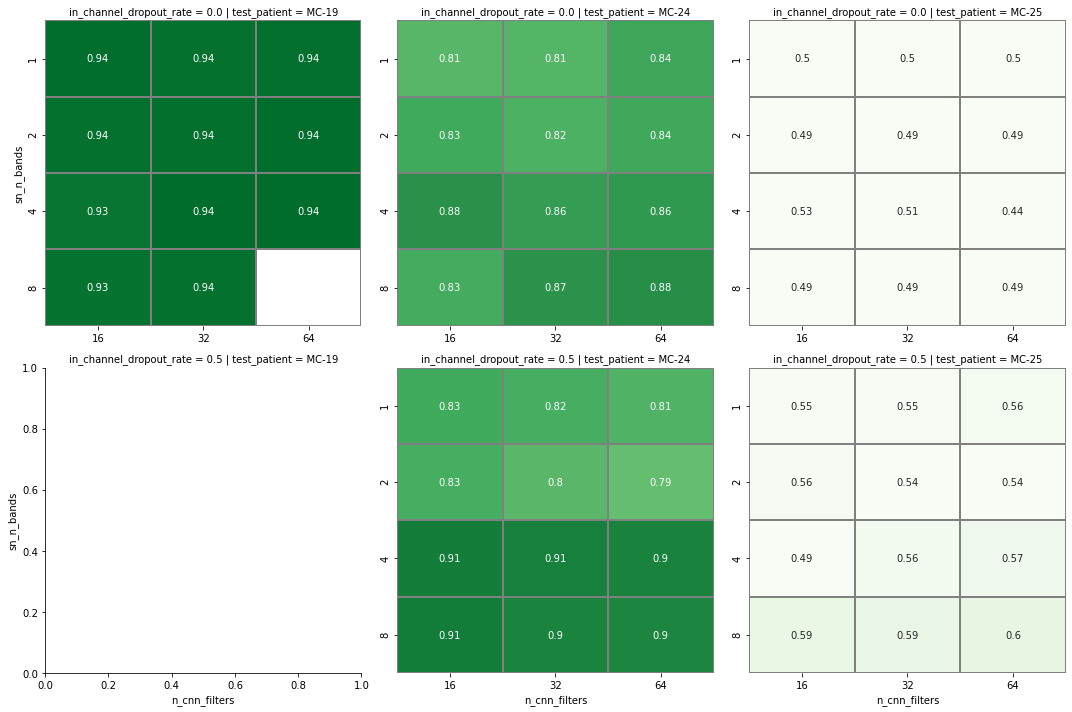

In [14]:
g = sns.FacetGrid(res_perf_df, col="test_patient", 
                  row='in_channel_dropout_rate',
                  # Sharing axis doesn't seem to work so well with sparse results - axes names and ticks get weird
                  sharex=False, sharey=False, height=5)
g.map_dataframe(hplot,'n_cnn_filters', 'sn_n_bands', 'f1',
                cmap='Greens', vmax=1., vmin=0.55, 
                cbar=False, linewidths=1, linecolor='grey')